# G16 Code for creating demo data

## 0. Load data

In [50]:
import pandas as pd
import numpy as np
import sys
print(sys.prefix)

c:\Users\Move\anaconda3\envs\epa133a


In [51]:
# import data
dir = '../data/raw/'
filename = 'BMMS_overview.xlsx'
df_bridges = pd.read_excel(dir + filename)

In [52]:
#df_bridges.head()

In [53]:
# import data
dir = '../data/raw/'
filename = '_roads3.csv' # replace this with the interpolated data
df_roads = pd.read_csv(dir + filename)

In [54]:
#df_roads.head()

In [55]:
# print shape of dataframes
print(df_bridges.shape)
print(df_roads.shape)

(20415, 20)
(51348, 8)


## 1. Remove duplicates from BMMS_overview.xlsx

In [56]:
df_bridges_clean = df_bridges.copy()
df_bridges_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20415 entries, 0 to 20414
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   road              20415 non-null  object 
 1   km                20415 non-null  float64
 2   type              20415 non-null  object 
 3   LRPName           20415 non-null  object 
 4   name              20100 non-null  object 
 5   length            20406 non-null  float64
 6   condition         20415 non-null  object 
 7   structureNr       20415 non-null  int64  
 8   roadName          20415 non-null  object 
 9   chainage          20415 non-null  float64
 10  width             17408 non-null  float64
 11  constructionYear  17407 non-null  float64
 12  spans             17408 non-null  float64
 13  zone              20415 non-null  object 
 14  circle            20415 non-null  object 
 15  division          20415 non-null  object 
 16  sub-division      20415 non-null  object

In [57]:
# add a new colum 'road_lrp' combines 'road' and 'lrp'
df_bridges_clean['road_lrp'] = df_bridges_clean['road'] + df_bridges_clean['LRPName']

# add a new column 'name_clean' equals to 'name' 
df_bridges_clean['name_clean'] = df_bridges_clean['name']

# add a new column 'road_chainage' equals to 'chainage', but turn float into string, combine 'road' and 'chainage'
df_bridges_clean['road_chainage'] = df_bridges_clean['chainage'].astype(str)
df_bridges_clean['road_chainage'] = df_bridges_clean['road'] + df_bridges_clean['road_chainage']


In [58]:

#df_bridges_clean.head()

In [59]:
# lower the letters 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.lower()

# delet space 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace(' ', '')

# delet hypen
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace('-', '')

# delet comma
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace(',', '')

# mark the unknown road name
df_bridges_clean.loc[df_bridges_clean['name_clean'] == '.', 'name_clean'] = 'unknown'

# delet period 
df_bridges_clean['name_clean'] = df_bridges_clean['name_clean'].str.replace('.', '')

In [60]:
df_bridges_clean.shape

(20415, 23)

In [61]:
# delete duplicate in both 'road_lrp' and 'road_chainage' columns
df_bridges_clean = df_bridges_clean.drop_duplicates(subset=['road_lrp','chainage'], keep='first')
df_bridges_clean.shape

(17518, 23)

In [62]:
# replace (r) with (right), (l) with (left) in column 'name_clean'
df_bridges_clean.loc[:, 'name_clean'] = df_bridges_clean['name_clean'].str.replace('right', 'r')
df_bridges_clean.loc[:, 'name_clean'] = df_bridges_clean['name_clean'].str.replace('left', 'l')

In [63]:
# find the duplicated value in 'road_chainage' column, show the unique values in 'name_clean' column
df_bridges_clean[df_bridges_clean.duplicated(subset=['road_chainage'], keep=False)].sort_values(by='road_chainage').name_clean.unique()

array(['darikandibridge(r)', 'darikandibridge(l)', 'sonakhalbridge(l)',
       'sonakhalbridge(r)', 'mollikparabridge(r)', 'marikhalibridge(r)',
       'marikhalibridge(l)', 'ashariarcharbridge(r)', 'ashirchar(r)',
       'asharirchar2bridge(r)', 'ashariachar2bridge(l)',
       'bhatercharbridge(l)', 'bhatercharbridge(r)', 'anarparabridge(l)',
       'anarparabridge(r)', 'bhabercharbridge(r)', 'bhabercharbridge(l)',
       'baushiabridge(r)', 'baushiabridge(l)', 'madhyabaushiabridge(l)',
       'madhyabaushiabridge(r)', 'baushiabazarbridge(l)',
       'baushiabazarbridge(r)', 'bridgeoverturagriver(r)',
       'salehpurbridge(r)', 'fulbariabridge(l)', 'fulbariabridge(r)',
       'zadircharbridge(r)', 'zadircharbridge(l)', 'jorpulbridge(r)',
       'jorpurbridge(l)', 'dhalapara', 'dobukay', 'kamarkhalbridge',
       'unknown', 'dabagrambridge', 'lalbaribridge', 'tairmukhbridge',
       'ghonurambridge', 'naudabosbridge', 'sambordbridge'], dtype=object)

In [64]:
# Function to filter bridges based on left or right (keep left bridge), and conditions (keep worse condition)
def filter_bridges(df):
    df = df.copy()
    
    # Condition priority (higher = worse condition)
    condition_priority = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    df['condition_priority'] = df['condition'].map(condition_priority)

    # Group by 'chainage'
    grouped = df.groupby('road_chainage')

    rows_to_keep = []

    for _, group in grouped:
        if len(group) == 1:  # If only one row exists for this chainage, keep it
            rows_to_keep.append(group.index[0])
            continue

        # Identify left and right bridges
        left_bridge = group[group['name_clean'].str.contains('(l)', na=False, regex=False)]
        right_bridge = group[group['name_clean'].str.contains('(r)', na=False, regex=False)]

        if not left_bridge.empty and not right_bridge.empty:
            # If both left and right exist, keep only the left bridge
            rows_to_keep.append(left_bridge.index[0])
        else: 
            # If two (r) or two (l) exist, or none of them exist, keep the one with the worst condition
            worst_bridge = group.sort_values(by='condition_priority', ascending=False).iloc[0]
            rows_to_keep.append(worst_bridge.name)

    # Keep only selected rows
    return df.loc[rows_to_keep].drop(columns=['condition_priority']).reset_index(drop=True)



In [65]:
# Apply function
df_bridges_clean = filter_bridges(df_bridges_clean)
df_bridges_clean.shape

(17494, 23)

In [66]:
# check the duplicated value in 'chainage' column
df_bridges_clean[df_bridges_clean.duplicated(subset=['road_chainage'], keep=False)].sort_values(by=['road_lrp'])

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,road_lrp,name_clean,road_chainage


In [67]:
df_bridges_clean.head(3)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,road_lrp,name_clean,road_chainage
0,N102,0.984,Box Culvert,LRPSc,PORISPUR BOX CULVERT,3.0,A,101312,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,0.984,...,Comilla,Comilla,Comilla,Gouripur,23.486582,91.113418,interpolate,N102LRPSc,porispurboxculvert,N1020.984
1,N102,10.530,Slab Culvert,LRP010c,CONSUNAGAR SLAB,0.9,A,108189,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,10.530,...,Comilla,Comilla,Comilla,Gouripur,23.555582,91.061578,interpolate,N102LRP010c,consunagarslab,N10210.53
2,N102,11.876,Box Culvert,LRP011a,HATAMARA BOX CULVERT.,3.2,A,101290,Comilla (Mainamati)-Brahmanbaria (Sarail) Road,11.876,...,Comilla,Comilla,Comilla,Gouripur,23.560419,91.055519,interpolate,N102LRP011a,hatamaraboxculvert,N10211.876


## 2. Remove duplicates from _roads3.csv

In [68]:
df_roads_clean = df_roads.copy()
df_roads_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51348 entries, 0 to 51347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   road      51348 non-null  object 
 1   chainage  51348 non-null  float64
 2   lrp       51348 non-null  object 
 3   lat       51348 non-null  float64
 4   lon       51348 non-null  float64
 5   gap       9074 non-null   object 
 6   type      51348 non-null  object 
 7   name      51348 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.1+ MB


In [69]:
# add a new column 'road_chainage' equals to 'chainage', but turn float into string, combine 'road' and 'chainage'
df_roads_clean['road_chainage'] = df_roads_clean['chainage'].astype(str)
df_roads_clean['road_chainage'] = df_roads_clean['road'] + df_roads_clean['road_chainage']

# add a new colum 'road_lrp' combines 'road' and 'lrp'
df_roads_clean['road_lrp'] = df_roads_clean['road'] + df_roads_clean['lrp']


In [70]:
#df_roads_clean.head()

In [71]:
# find the duplicated value in 'road_lrp' column
df_roads_clean[df_roads_clean.duplicated(subset=['road_lrp'], keep=False)].sort_values(by='road_lrp')


,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp
27331,Z2002,28.005,LRPE,24.358056,91.962778,NaN,KmPost,Km post missing,Z200228.005,Z2002LRPE
27347,Z2002,33.089,LRPE,24.322944,91.995861,NaN,Others,Road end at Chatla Cheek Post,Z200233.089,Z2002LRPE
50500,Z8740,3.315,LRP003c,22.424666,90.090389,BS,Bridge,Baily Bridge start,Z87403.315,Z8740LRP003c
50498,Z8740,3.276,LRP003c,22.424694,90.090389,BS,Bridge,baily brije start,Z87403.276,Z8740LRP003c
50501,Z8740,3.327,LRP003d,22.424860,90.090305,BE,Bridge,Baily Bridge end,Z87403.327,Z8740LRP003d
50499,Z8740,3.288,LRP003d,22.424860,90.090305,BE,Bridge,baily brije end,Z87403.288,Z8740LRP003d
50511,Z8740,5.111,LRP005a,22.429305,90.074749,BS,Bridge,brije start,Z87405.111,Z8740LRP005a
50513,Z8740,5.141,LRP005a,22.429305,90.074749,BS,Bridge,Bridge start,Z87405.141,Z8740LRP005a
50512,Z8740,5.133,LRP005b,22.429249,90.074527,BE,Bridge,brije end,Z87405.133,Z8740LRP005b
50514,Z8740,5.163,LRP005b,22.429249,90.074527,BE,Bridge,Bridge end,Z87405.163,Z8740LRP005b


In [72]:
# check rows between index 27330 and 27347
df_roads_clean.loc[27330:27347]


,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp
27330,Z2002,27.645,LRP027c,24.361056,91.961000,NaN,Culvert,Box culvert,Z200227.645,Z2002LRP027c
27331,Z2002,28.005,LRPE,24.358056,91.962778,NaN,KmPost,Km post missing,Z200228.005,Z2002LRPE
27332,Z2002,29.005,LRP029,24.351472,91.969583,NaN,KmPost,Km post missing,Z200229.005,Z2002LRP029
27333,Z2002,29.027,LRP029a,24.351333,91.969694,NaN,Culvert,Box culvert,Z200229.027,Z2002LRP029a
27334,Z2002,29.509,LRP029b,24.348666,91.973416,NaN,Culvert,Box culvert,Z200229.509,Z2002LRP029b
27335,Z2002,29.880,LRP029c,24.346333,91.975972,NaN,Culvert,Box culvert,Z200229.88,Z2002LRP029c
27336,Z2002,29.975,LRP030,24.345611,91.976499,NaN,KmPost,Information missing,Z200229.975,Z2002LRP030
27337,Z2002,30.342,LRP030a,24.340055,91.978388,NaN,Culvert,Box culvert,Z200230.342,Z2002LRP030a
27338,Z2002,30.975,LRP031,24.337944,91.981694,NaN,KmPost,Information missing,Z200230.975,Z2002LRP031
27339,Z2002,30.983,LRP031a,24.337916,91.981722,NaN,Culvert,Box culvert,Z200230.983,Z2002LRP031a


In [73]:
# manually change the lrp in row 27331 to 'LRP028', road_lrp to 'Z2002LRP028'
df_roads_clean.loc[27331, 'lrp'] = 'LRP028'
df_roads_clean.loc[27331, 'road_lrp'] = 'Z2002LRP028'

In [74]:
# clean the duplicated road_lrp, as all the bridge information come from BMMW_overview.xlsx
df_roads_clean = df_roads_clean.drop_duplicates(subset=['road_lrp'], keep='first')

In [75]:
# check the duplicated value in 'road_lrp' column
df_roads_clean[df_roads_clean.duplicated(subset=['road_lrp'], keep=False)].sort_values(by='road_lrp')

,road,chainage,lrp,lat,lon,gap,type,name,road_chainage,road_lrp


## 3. Combine data from BMMS_overview.xlsx & _roads3.csv

In [76]:
# change the column names of the bridges dataframe: LRPName -> lrp
df_bridges_clean.rename(columns={'LRPName': 'lrp'}, inplace=True)


In [77]:
# add a column named 'model_type' to the df_bridges dataframe and fill it with 'bridge'
df_bridges_clean['model_type'] = 'bridge'

# add a column named 'model_type' to the df_roads dataframe and fill it with 'link';
# but if the last character in the column 'lrp' isn't number, fill it with 'bridge', except for 'S' and 'E'
df_roads_clean['model_type'] = 'link'
df_roads_clean.loc[df_roads['lrp'].str[-1].str.isnumeric() == False, 'model_type'] = 'bridge'
df_roads_clean.loc[df_roads['lrp'].str[-1] == 'S', 'model_type'] = 'link'
df_roads_clean.loc[df_roads['lrp'].str[-1] == 'E', 'model_type'] = 'link'


In [78]:
#df_roads

In [79]:
# make a copy of the df_bridges dataframe and name it df_bridges_original
df_bridges_original = df_bridges_clean.copy()

# merge the df_bridges and df_roads dataframes
df_concat = pd.concat([df_bridges_clean, df_roads_clean])

In [80]:
#df_concat.head()

In [81]:
# sort the df_concat dataframe, groupedby 'road', by 'chainage'
df_concat = df_concat.sort_values(by=['road', 'chainage'])

In [82]:
#df_concat.head()

## 4. Build the demo dataframe w/ 'sourcesink'

In [83]:
# if the 'model_type' is 'bridge' and the 'condition' is NaN, drop the row; Keep the rows with 'model_type' as 'link'
df_concat = df_concat[~((df_concat['model_type'] == 'bridge') & (df_concat['condition'].isna())) | (df_concat['model_type'] == 'link')]

In [84]:
# Initialize an empty list to store the rows of the new DataFrame
new_rows = []

# Iterate over each unique road in df_concat
for road in df_concat['road'].unique():
    road_rows = df_concat[df_concat['road'] == road].reset_index(drop=True)
    for i, row in road_rows.iterrows():
        if i == 0:
            model_type = 'sourcesink'
        elif i == len(road_rows) - 1:
            model_type = 'sourcesink'
        else:
            model_type = row['model_type']
        
        length = 0 if i == 0 else row['chainage'] - road_rows.loc[i-1, 'chainage']
        new_row = {
            'road': row['road'],
            'id': f"{row['road']}_{i}",
            'model_type': model_type,
            'name': row['name'],
            'lat': row['lat'],
            'lon': row['lon'],
            'length': length,
            'condition': row['condition'],
            'road_lrp': row['road_lrp']
        }
        new_rows.append(new_row)

# Convert the list to a DataFrame
df_all_roads = pd.DataFrame(new_rows)

In [85]:
df_all_roads[(df_all_roads['road'] == 'N1') | (df_all_roads['road'] == 'N2')]

,road,id,model_type,name,lat,lon,length,condition,road_lrp
0,N1,N1_0,sourcesink,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000,NaN,N1LRPS
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.000,NaN,N1LRP001
2,N1,N1_2,bridge,.,23.698739,90.458861,0.800,A,N1LRP001a
3,N1,N1_3,link,Km post missing,23.697889,90.460583,0.200,NaN,N1LRP002
4,N1,N1_4,link,Km post missing,23.693833,90.469138,1.000,NaN,N1LRP003
...,...,...,...,...,...,...,...,...,...
2564,N2,N2_747,bridge,.,25.171993,92.020065,0.347,A,N2LRP285b
2565,N2,N2_748,bridge,.,25.171049,92.018726,0.180,A,N2LRP285c
2566,N2,N2_749,link,Km post broken,25.170055,92.016389,0.298,NaN,N2LRP286
2567,N2,N2_750,link,Jaflong 1 km,25.162889,92.017110,1.000,NaN,N2LRP287


## 6. Filter only N1, N2, and their side roads (N1xx, N2XX)

In [86]:
# Filter the dataframe to include only roads N1, N2, and their side roads (N1xx, N2xx)
df_filtered = df_all_roads[df_all_roads['road'].str.match(r'^(N1|N2)\d*$')]

# Display the filtered dataframe
df_filtered

,road,id,model_type,name,lat,lon,length,condition,road_lrp
0,N1,N1_0,sourcesink,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000,NaN,N1LRPS
1,N1,N1_1,link,Km post missing,23.702139,90.451972,1.000,NaN,N1LRP001
2,N1,N1_2,bridge,.,23.698739,90.458861,0.800,A,N1LRP001a
3,N1,N1_3,link,Km post missing,23.697889,90.460583,0.200,NaN,N1LRP002
4,N1,N1_4,link,Km post missing,23.693833,90.469138,1.000,NaN,N1LRP003
...,...,...,...,...,...,...,...,...,...
2954,N210,N210_8,link,Dhaka 248 Km,24.857861,91.927638,1.100,NaN,N210LRP008
2955,N210,N210_9,link,Dhaka 247 Km,24.849916,91.922916,1.000,NaN,N210LRP009
2956,N210,N210_10,link,Dhaka 246 Km,24.846833,91.914028,1.000,NaN,N210LRP010
2957,N210,N210_11,link,Dhaka 245 Km,24.847472,91.904167,1.000,NaN,N210LRP011


In [87]:
# print the shape of the filtered dataframe
df_filtered.shape

(2959, 9)

In [88]:
# print unique values in 'road' column
df_filtered['road'].unique()

array(['N1', 'N101', 'N102', 'N103', 'N104', 'N105', 'N106', 'N107',
       'N108', 'N109', 'N110', 'N111', 'N112', 'N119', 'N120', 'N123',
       'N128', 'N129', 'N2', 'N203', 'N204', 'N205', 'N206', 'N207',
       'N208', 'N209', 'N210'], dtype=object)

In [89]:
# count model_type == 'sourcesink' in the filtered dataframe
df_filtered['model_type'].value_counts()

model_type
bridge        1641
link          1264
sourcesink      54
Name: count, dtype: int64

## 7. Define intersections

## 8. Save demo file as a csv

In [90]:
df_demo = df_filtered.copy()

In [91]:
# save the df_demo dataframe to a csv file
dir = '../data/processed/'
filename = 'demo_100.csv'
df_demo.to_csv(dir + filename, index=False)

## 9. Plot roads

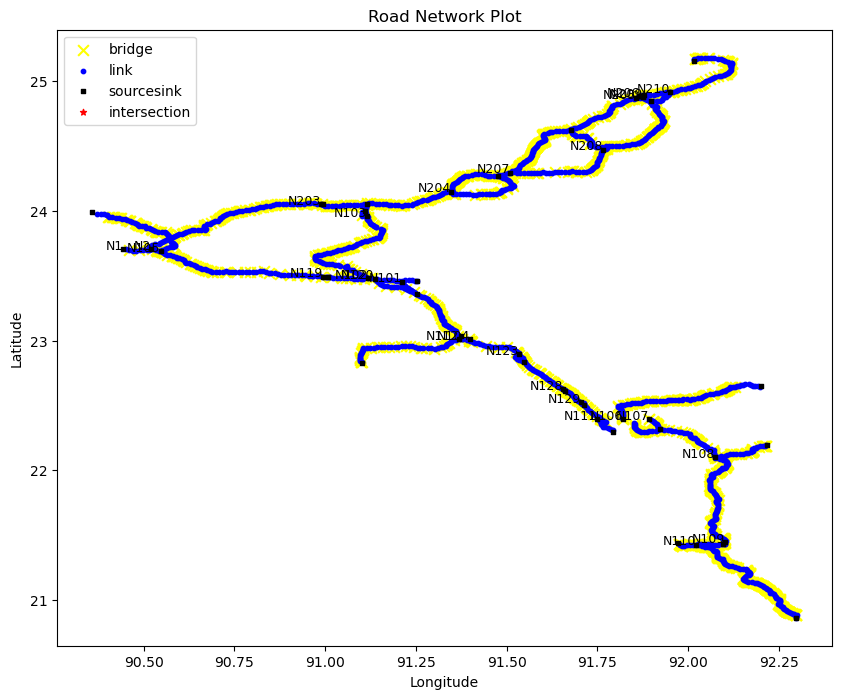

In [98]:
import matplotlib.pyplot as plt

# Define colors and markers for each model type
colors = {
    'bridge': 'yellow',
    'link': 'blue',
    'sourcesink': 'black',
    'intersection': 'red'
}

markers = {
    'bridge': 'x',
    'link': 'o',
    'sourcesink': 's',
    'intersection': '*'
}

marker_sizes = {
    'bridge': 60,
    'link': 10,
    'sourcesink': 10,
    'intersection': 20
}

# Create a scatter plot
plt.figure(figsize=(10, 8))

for model_type, color in colors.items():
    subset = df_demo[df_demo['model_type'] == model_type]
    plt.scatter(subset['lon'], subset['lat'], c=color, label=model_type, s=marker_sizes[model_type], marker=markers[model_type])

# Annotate the first data point of each road with the road name
for road in df_demo['road'].unique():
    first_point = df_demo[df_demo['road'] == road].iloc[0]
    plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network Plot')
plt.legend()
plt.show()